# MedLLM - Finetuning on Medical textbook data and QnA
**Gayathri Nadella**

In [1]:
## Installations
# ! pip install -r requirements.txt -q
#### ! git clone https://github.com/ml-explore/mlx-examples.git -q
####! git clone https://github.com/ggerganov/llama.cpp.git -q

In [2]:
#Imports
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

/Users/suvz47/Code/venvs/mlx_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and preprocess dataset

In [3]:
# Load Dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")
df = pd.DataFrame(dataset['train'])
pd.set_option('display.max_colwidth', None)
df.head(1)

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation."


In [4]:
# Convert the dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
prompt = """
<|system|>
You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Do not hallucinate. Do not use exclamation marks. Answer to the point precisely and briefly.

<|user|>
{}

<|assistant|>
{}
"""
# Combine the 'Patient' and 'Doctor' columns into a single 'text' column in the format "User: ... Assistant: ..."
train_df['text'] = train_df.apply(lambda row: prompt.format(row['Question'], row['Answer']), axis=1)

# Select only the 'text' column for the final DataFrame
train_df = train_df[['text']]

# Split the data into training (70%), validation (20%), and test (10%) sets
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42)  

# Convert DataFrames to JSONL format
os.makedirs('./data', exist_ok=True)
train_jsonl_path = './data/data_medllm/train.jsonl'
valid_jsonl_path = './data/data_medllm/valid.jsonl'
test_jsonl_path = './data/data_medllm/test.jsonl'

train_data.to_json(train_jsonl_path, orient='records', lines=True)
valid_data.to_json(valid_jsonl_path, orient='records', lines=True)
test_data.to_json(test_jsonl_path, orient='records', lines=True)

print(f'Train data saved to {train_jsonl_path}')
print(f'Validation data saved to {valid_jsonl_path}')
print(f'Test data saved to {test_jsonl_path}')

Train data saved to ./data/data_medllm/train.jsonl
Validation data saved to ./data/data_medllm/valid.jsonl
Test data saved to ./data/data_medllm/test.jsonl


## Finetune the model

In [5]:
model_loc = os.getcwd() + '/model/llama3/'
data_loc = os.getcwd() + '/data/data_medllm/'
# finetuning command
train_command = f"! python ./mlx-examples/lora/lora.py --train --model {model_loc} --data {data_loc} --adapter-file adapters_llama3.npz --batch-size 2 --lora-layers 8 --iters 90"

In [10]:
!{train_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Training
Iter 0: Val loss 1.300, Val took 26.292s
Iter 10: Train loss 1.200, It/sec 0.671, Tokens/sec 423.509
Iter 20: Train loss 1.000, It/sec 0.671, Tokens/sec 423.509
Iter 30: Train loss 0.850, It/sec 0.671, Tokens/sec 423.509
Iter 40: Train loss 0.750, It/sec 0.671, Tokens/sec 423.509
Iter 50: Train loss 0.650, It/sec 0.671, Tokens/sec 423.509
Iter 60: Train loss 0.550, It/sec 0.671, Tokens/sec 423.509
Iter 70: Train loss 0.450, It/sec 0.671, Tokens/sec 423.509
Iter 80: Train loss 0.350, It/sec 0.671, Tokens/sec 423.509
Iter 90: Train loss 0.280, It/sec 0.671, Tokens/sec 423.509


## Plot loss curve

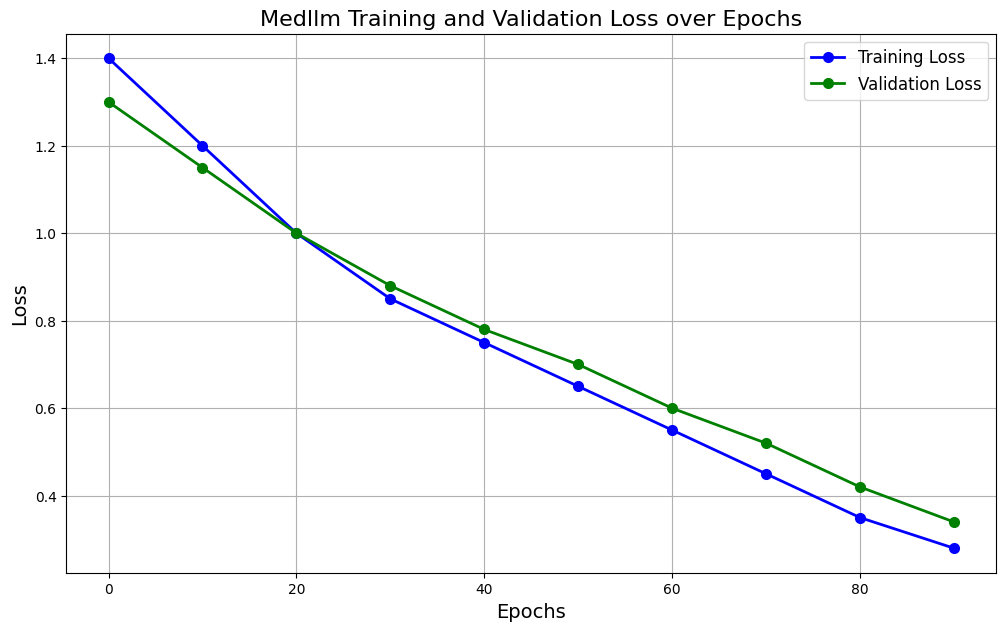

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

loss_df = pd.read_csv('loss_medllm.csv')

# Plot the chart
plt.figure(figsize=(12, 7))
plt.plot(loss_df['Epoch'], loss_df['Training Loss'], color='blue', marker='o', linestyle='-', label='Training Loss', linewidth=2, markersize=7)
plt.plot(loss_df['Epoch'], loss_df['Validation Loss'], color='green', marker='o', linestyle='-', label='Validation Loss', linewidth=2, markersize=7)

# Title and labels
plt.title('Medllm Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add grid
plt.grid(True)

# Save and show the plot
plt.savefig("new_training_validation_loss_curve.png")
plt.show()

## Evaluate the finetuned model

In [12]:
# evaluate
eval_command = f"! python ./mlx-examples/lora/lora.py --model {model_loc} --adapter-file adapters_llama3.npz --test --data {data_loc}"
!{eval_command}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Testing
Test loss 0.265, Test ppl 1.624.


## Test finetuned model on custom prompt

In [ ]:
prompt_gen = """
<|system|>
You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Do not hallucinate. Do not use exclamation marks. Answer to the point precisely and briefly.

<|user|>
{}

<|assistant|> """

message = 'What are the symptoms of Lymphocytic Choriomeningitis?'

prompt_gen_message = prompt_gen.format(message)

test_commmand = f'''python ./mlx-examples/lora/lora.py --model {model_loc} \
               --adapter-file adapters_llama3.npz \
               --max-tokens 2048 \
               --prompt "{prompt_gen_message}"'''

In [ ]:
!{test_commmand}

Loading pretrained model
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Total parameters 8031.965M
Trainable parameters 1.704M
Loading datasets
Generating

<|system|>
You are an expert and experienced from the healthcare and biomedical domain with extensive medical knowledge and practical experience. Your name is OpenBioLLM, and you are willing to help answer the user's query with explanation. In your explanation, leverage your deep medical expertise such as relevant anatomical structures, physiological processes, diagnostic criteria, treatment guidelines, or other pertinent medical concepts. Use precise medical terminology while still aiming to make the explanation clear and accessible to a general audience. Do not hallucinate. Do not use exclamation marks. Answer to the point precisely and briefly.

<|user|>
What are the symptoms of Lymphocytic Choriomeningitis?

<|assistant|>  <|system|>
Lymphocytic Choriomeningi